 # Сборный проект.
  
<b>Описание проекта</b>

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также поможет понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работаем с одними и теми же данными.

## Шаг. Откроем файл с данными и изучим общую информацию.

**Путь к файлу**
- `/datasets/logs_exp.csv`.

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [2]:
#код загрузки датасета

import os
    
logs_exp = '/logs_exp.csv'
if os.path.exists(logs_exp):
   logs_exp = pd.read_csv(logs_exp, sep='\t')
else:
    print('Something is wrong')

logs_exp.info()
display(logs_exp.head(10));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


## Шаг. Подготовим данные
### Заменим названия столбцов на удобные, проверим наличие дубликатов.

In [3]:
#Заменим названия столбцов (приведем к нижнему регистру)
logs_exp.columns = map(str.lower, logs_exp.columns)
logs_exp.columns=['event', 'deviceid', 'timestamp', 'group']
#Проверяем наличие дубликатов
print(logs_exp.duplicated().sum())

413


In [4]:
#Удалим дубликаты
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

### Проверим пропуски и типы данных. Откорректируем, если нужно;

In [5]:
#Проверяем типы данных
logs_exp.info()
#Проверяем наличие пропусков
pd.DataFrame(round(logs_exp.isna().mean()*100,1)).style.background_gradient('coolwarm')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      243713 non-null  object
 1   deviceid   243713 non-null  int64 
 2   timestamp  243713 non-null  int64 
 3   group      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


,0
event,0.000000
deviceid,0.000000
timestamp,0.000000
group,0.000000


### Добавим столбец даты и времени, а также отдельный столбец дат;

In [6]:
logs_exp['datetime'] = pd.to_datetime(logs_exp['timestamp'], unit='s')
logs_exp['date'] = logs_exp['datetime'].dt.date
#Проверяем типы данных
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   deviceid   243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  int64         
 4   datetime   243713 non-null  datetime64[ns]
 5   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [7]:
#Поменяем тип данных у колонки date
logs_exp['date'] = logs_exp['date'].astype('datetime64')

**Вывод**

Провели процесс обработки данных:

1. Заменили названия столбцов, удалили дубликаты.
2. Проверили пропуски и типы данных.
2. Добавили столбцы с датой и временем, а также датой.

In [8]:
# выделили клиентов, попавших более чем в одну группу
bad_clients = logs_exp.groupby('deviceid').agg({'group' : 'nunique'}).reset_index().query('group>1')['deviceid']
display(bad_clients)

Series([], Name: deviceid, dtype: int64)

## Шаг. Изучим и проверим данные.
### Сколько всего событий в логе?

In [9]:
events = logs_exp['event'].count()
print('Всего событий в таблице =', events)

Всего событий в таблице = 243713


### Сколько всего пользователей в логе?

In [10]:
users = logs_exp['deviceid'].nunique()
print('Уникальных пользователей в таблице =', users)

Уникальных пользователей в таблице = 7551


### Сколько в среднем событий приходится на пользователя?

In [11]:
events_by_users = events / users
print("Среднее кол-во событий на пользователя =", round(events_by_users))

Среднее кол-во событий на пользователя = 32


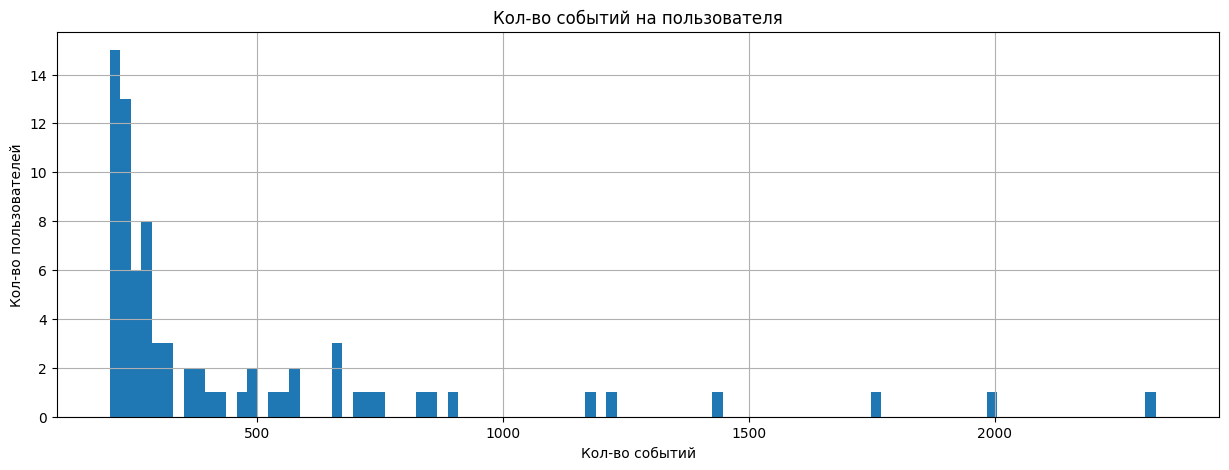

In [12]:
event_per_user = logs_exp.groupby('deviceid')['event'].count()
plt.figure(figsize=(15,5))
plt.hist(event_per_user, bins=100, range=(200,2350)) 
plt.xlabel('Кол-во событий')
plt.grid()
plt.ylabel('Кол-во пользователей')
plt.title('Кол-во событий на пользователя');

**Вывод**

На одного пользователя приходится до 2307 событий. Поскольку есть такой выброс, то лучше использовать не среднее, а медианное значение событий на пользователя. Оно равно 19. 

In [13]:
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

In [14]:
event_per_user.median()

20.0

### Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можем ли быть увереннымы, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?

In [15]:
#Найдем максимульную и минимальную даты
print("Минимальная дата:", logs_exp['datetime'].min())
print("Максимальная дата:", logs_exp['datetime'].max())
#Получим период
print("Период:", logs_exp['datetime'].max()-logs_exp['datetime'].min())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Период: 13 days 16:31:41


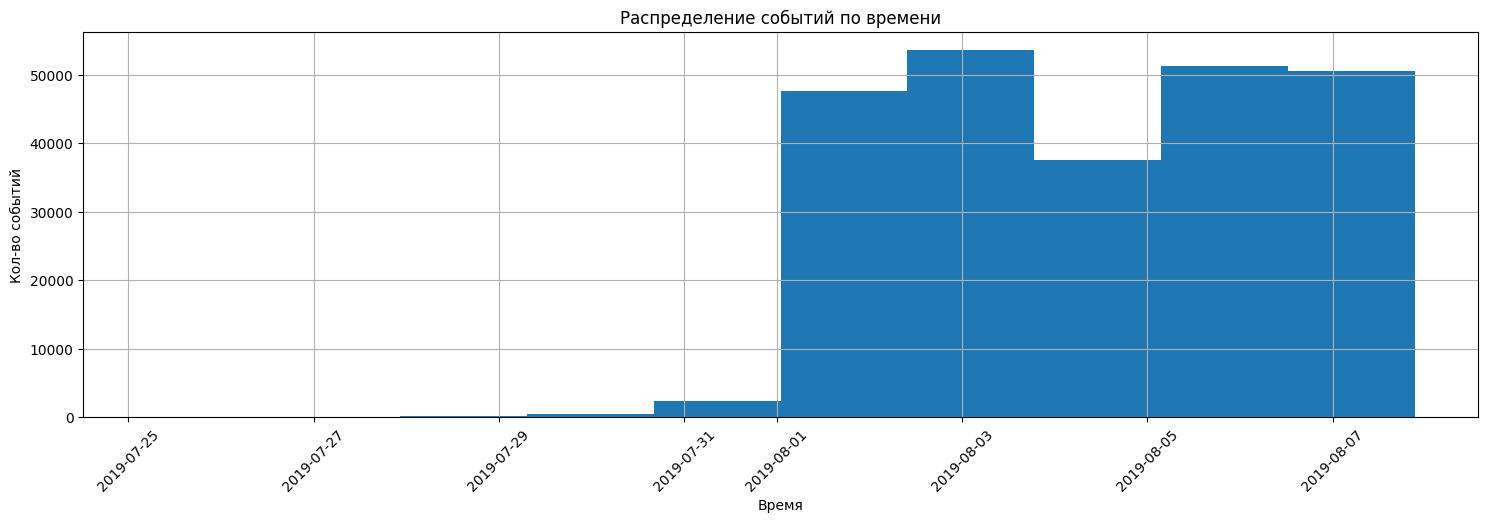

In [16]:
plt.figure(figsize=(18,5))
plt.grid()
plt.xticks(rotation=45)
logs_exp['datetime'].hist()
plt.xlabel('Время')
plt.ylabel('Кол-во событий')
plt.title('Распределение событий по времени');
plt.show();

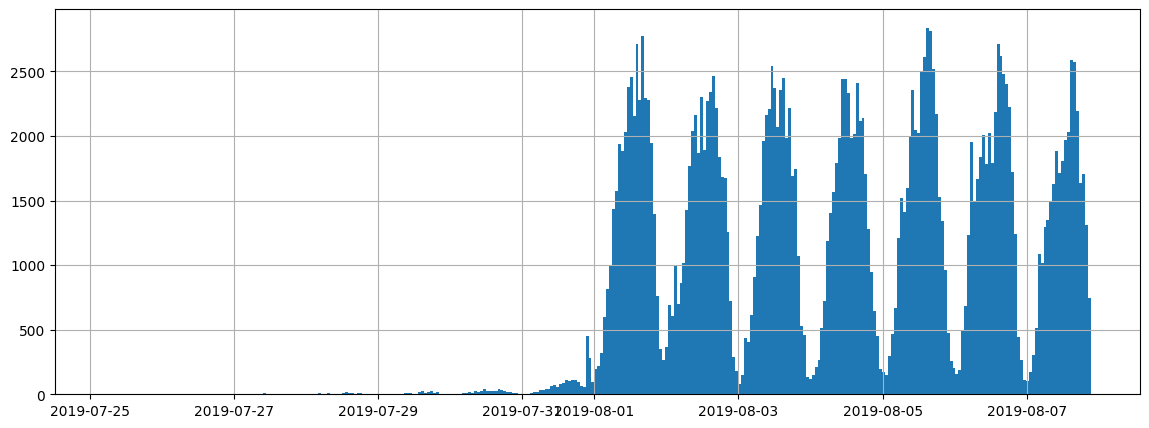

In [17]:
# код ревьюера
logs_exp['datetime'].hist(bins=14*24, figsize=(14, 5));

**Вывод**

На графике видно, что в июле очень мало событий. Основное кол-во приходится на август. В итоге получается, что полноценные данные есть только за август.
Мы принимаем решение, что будем проводить анализ и тестирование только на основе данных за август( с 1 августа по 7 августа включительно).

In [18]:
logs_exp = logs_exp.loc[logs_exp['datetime'] > '2019-08-01 00:00:00'].reset_index(drop=True)
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240887 entries, 0 to 240886
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      240887 non-null  object        
 1   deviceid   240887 non-null  int64         
 2   timestamp  240887 non-null  int64         
 3   group      240887 non-null  int64         
 4   datetime   240887 non-null  datetime64[ns]
 5   date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.0+ MB


### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [19]:
users_query = logs_exp['deviceid'].nunique()
print(f"Было пользователей = {users} / Стало пользователей = {users_query} / Разница = {users-users_query} / Относительные потери = {round((users-users_query)/users*100,2)}%")


events_query = logs_exp['event'].count()
print(f"Было событий = {events} / Стало событий = {events_query} / Разница = {events-events_query} / Относительные потери = {round((events-events_query)/events*100,2)}%")


Было пользователей = 7551 / Стало пользователей = 7534 / Разница = 17 / Относительные потери = 0.23%
Было событий = 243713 / Стало событий = 240887 / Разница = 2826 / Относительные потери = 1.16%


**Вывод**

Отбросив старые данные, мы потеряли 0,23% пользователей и 1,16% событий.
Потери допустимые.

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [20]:
logs_exp['group'].unique()

array([246, 247, 248])

**Вывод**

Пользователи всех трех групп присутствуют.

**ОБЩИЙ ВЫВОД**

- В ходе изучения и проверки данных выяснили, что период предоставленных данных 13 дней. 
- Кол-во событий в июле резко выделяется по сравнению с августом. Ввиду этого мы приняли решение эти данные убрать из анализа. 
- После отброса этих данных мы получили относительные потери в размере 0,23% пользователей и 1,16% событий. Потери допустимые и на дальнейший анализ не должны сильно повлиять.

## Шаг. Изучим воронку событий
### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [21]:
logs_exp['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [22]:
events_users = logs_exp.groupby('event').agg({'deviceid':'nunique'}).sort_values(by='deviceid', ascending=False)
events_users['share_of_total'] = (events_users / users_query * 100).round(1) # доля хотя бы раз совершивших событие
events_users.columns = ['users', 'share_of_total']
events_users=events_users.reset_index()
events_users

,event,users,share_of_total
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Не будем их учитывать при расчёте воронки.

**Предположение порядка происхождения событий**

    1. MainScreenAppear - Появление Главного экрана(переход на сайт)
    2. OffersScreenAppear - Появление Экрана Предложений(переход на прайс-лист)
    3. CartScreenAppear - Появление Экрана Корзины(переход в корзину)
    4. PaymentScreenSuccessful - Экран удачного совершения платежа(переход к оплате)
    5. Tutorial - Руководство пользователя(рекомендации)

В принципе по количеству событий такой порядок логичен и подтверждается цифрами. Кто-то последним пунктом не пользуется, скорее всего. 

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [23]:
prev_users = events_users.loc[0,'users']
start_users = prev_users

for i in events_users.index:
    events_users.loc[i,'share_of_prev'] = (events_users.loc[i,'users'] / prev_users * 100).round(1)
    events_users.loc[i,'share_from_first'] = (events_users.loc[i,'users'] / start_users * 100).round(1)
    prev_users = events_users.loc[i,'users']
events_users  

,event,users,share_of_total,share_of_prev,share_from_first
0,MainScreenAppear,7419,98.5,100.0,100.0
1,OffersScreenAppear,4593,61.0,61.9,61.9
2,CartScreenAppear,3734,49.6,81.3,50.3
3,PaymentScreenSuccessful,3539,47.0,94.8,47.7
4,Tutorial,840,11.1,23.7,11.3


### Выясним на каком шаге теряем больше всего пользователей.

Из таблицы выше видно, что очень много пользователей (38,1%) не попадают на второе событие. Возможно есть какая-то проблема на первом событии. Надо об этом сообщить тестировщикам или отделу маркетинга.

### Выясним какая доля пользователей доходит от первого события до оплаты.

Из таблицы пункта 4.4 видно, что по сравнению с первым событием, также много пользователей теряется при переходе на второй шаг. И доля пользователей дошедших от первого события до оплаты составляет 47,7%.

**ОБЩИЙ ВЫВОД**

Предположение порядка происхождения событий получается таким:

    1. MainScreenAppear - Появление Главного экрана(переход на сайт)
    2. OffersScreenAppear - Появление Экрана Предложений(переход на прайс-лист)
    3. CartScreenAppear - Появление Экрана Корзины(переход в корзину)
    4. PaymentScreenSuccessful - Экран удачного совершения платежа(переход к оплате)
    5. Tutorial - Руководство пользователя(рекомендации)

На второй этап воронки попадает 61,9% пользователей, а 38,1% отваливаются. Возможно есть какая-то проблема на первом событии. Надо об этом сообщить тестировщикам или отделу маркетинга.

С первого экрана до платежа доходят 47,7% пользователей. Это весьма хороший результат.

In [24]:
funnel = go.Figure(go.Funnel(x = events_users['share_from_first'], y = events_users['event']))
funnel.show();

## Шаг. Изучим результаты эксперимента
### Выясним сколько пользователей в каждой экспериментальной группе.

In [25]:
group_246_count = logs_exp.query('group == 246')['deviceid'].nunique()
print("Всего в группе 246 пользователей = ", group_246_count)
group_247_count = logs_exp.query('group == 247')['deviceid'].nunique()
print("Всего в группе 247 пользователей = ", group_247_count)
group_248_count = logs_exp.query('group == 248')['deviceid'].nunique()
print("Всего в группе 248 пользователей = ", group_248_count)

Всего в группе 246 пользователей =  2484
Всего в группе 247 пользователей =  2513
Всего в группе 248 пользователей =  2537


In [26]:
group_count = logs_exp.groupby('group')['deviceid'].nunique()
print(group_count)

group
246    2484
247    2513
248    2537
Name: deviceid, dtype: int64


**Вывод**

Разбивку на группы можно считать корректной.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Критерии успешного A/A-теста: 
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

**Вывод**

Статистически значимой разницы между выборками 246 и 247 нет.

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем тоже самое для всех других событий (удобно обернем проверку в отдельную функцию). Выясним, можно ли сказать, что разбиение на группы работает корректно.

В пункте 4.1 мы выяснили, что самым популярным событием является MainScreenAppear - Появление Главного экрана(переход на сайт).

In [27]:
#Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп:
event_group_test = logs_exp.pivot_table(
    index='event', 
    columns='group', 
    values='deviceid',
    aggfunc='nunique').sort_values(by=246, ascending=False)
event_group_test = event_group_test.reset_index()
#Посчитаем долю пользователей, совершивших это событие в каждой из контрольных групп:
event_group_test['share_246'] = (event_group_test[246] / group_246_count * 100).round(1)
event_group_test['share_247'] = (event_group_test[247] / group_247_count * 100).round(1)
event_group_test['share_248'] = (event_group_test[247] / group_248_count * 100).round(1)
#Посчитаем количество пользователей, совершивших это событие:
event_group_test['all'] = event_group_test[246] + event_group_test[247]+event_group_test[248]
#Посчитаем долю пользователей, совершивших это событие:
event_group_test['share_all'] = (event_group_test['all'] / (group_246_count+group_247_count+group_248_count) * 100).round(1)
display(event_group_test)

group,event,246,247,248,share_246,share_247,share_248,all,share_all
0,MainScreenAppear,2450,2476,2493,98.6,98.5,97.6,7419,98.5
1,OffersScreenAppear,1542,1520,1531,62.1,60.5,59.9,4593,61.0
2,CartScreenAppear,1266,1238,1230,51.0,49.3,48.8,3734,49.6
3,PaymentScreenSuccessful,1200,1158,1181,48.3,46.1,45.6,3539,47.0
4,Tutorial,278,283,279,11.2,11.3,11.2,840,11.1


**Вывод**

Число пользователей совершивших самое популярное событие "MainScreenAppear" - 7419, в разрезе групп:

246 - 2450

247 - 2476

248 - 2493

Доли пользователей совершивших самое популярное событие "MainScreenAppear" - 98,5%.

Для проверки гипотезы придумаем нулевую и альтернативную гипотезы:

**Нулевую гипотеза: нет оснований считать доли разными.**

**Альтернативная гипотеза: между долями есть значимая разница.**

In [28]:
users_by_group = logs_exp.groupby('group')['deviceid'].nunique()
users_by_group['246+247'] = users_by_group[246] + users_by_group[247]
display(users_by_group)

#Проверим, будет ли отличие между группами статистически достоверным:
def z_test(group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / users_by_group[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / users_by_group[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_by_group[group1] + users_by_group[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_by_group[group1] + 1/users_by_group[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)
        print('{} p-значение: {}'.format(event_group_test['event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу")
        else:
            print("Не получилось отвергнуть нулевую гипотезу")
        print('')

z_test(246, 247, 0.05)

group
246        2484
247        2513
248        2537
246+247    4997
Name: deviceid, dtype: int64

MainScreenAppear p-значение: 0.757
Не получилось отвергнуть нулевую гипотезу

OffersScreenAppear p-значение: 0.248
Не получилось отвергнуть нулевую гипотезу

CartScreenAppear p-значение: 0.229
Не получилось отвергнуть нулевую гипотезу

PaymentScreenSuccessful p-значение: 0.115
Не получилось отвергнуть нулевую гипотезу

Tutorial p-значение: 0.938
Не получилось отвергнуть нулевую гипотезу



**Вывод**

Статистически значимой разницы между выборками 246 и 247 нет для всех событий.

### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Сделаем выводы из эксперимента.

In [29]:
z_test(246, 248, 0.05)

MainScreenAppear p-значение: 0.295
Не получилось отвергнуть нулевую гипотезу

OffersScreenAppear p-значение: 0.208
Не получилось отвергнуть нулевую гипотезу

CartScreenAppear p-значение: 0.078
Не получилось отвергнуть нулевую гипотезу

PaymentScreenSuccessful p-значение: 0.212
Не получилось отвергнуть нулевую гипотезу

Tutorial p-значение: 0.826
Не получилось отвергнуть нулевую гипотезу



In [30]:
z_test(247, 248, 0.05)

MainScreenAppear p-значение: 0.459
Не получилось отвергнуть нулевую гипотезу

OffersScreenAppear p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу

CartScreenAppear p-значение: 0.579
Не получилось отвергнуть нулевую гипотезу

PaymentScreenSuccessful p-значение: 0.737
Не получилось отвергнуть нулевую гипотезу

Tutorial p-значение: 0.765
Не получилось отвергнуть нулевую гипотезу



In [31]:
#Сравним результаты с объединённой контрольной группой:
event_group_test['246+247'] = event_group_test[246] + event_group_test[247]
z_test('246+247', 248, 0.05)

MainScreenAppear p-значение: 0.294
Не получилось отвергнуть нулевую гипотезу

OffersScreenAppear p-значение: 0.434
Не получилось отвергнуть нулевую гипотезу

CartScreenAppear p-значение: 0.182
Не получилось отвергнуть нулевую гипотезу

PaymentScreenSuccessful p-значение: 0.6
Не получилось отвергнуть нулевую гипотезу

Tutorial p-значение: 0.765
Не получилось отвергнуть нулевую гипотезу



**Вывод**

Статистически значимой разницы между выборками нет для всех событий.

### Выберем уровень значимости при проверке статистических гипотез выше. Посчитаем, сколько проверок статистических гипотез мы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Выясним, какой уровень значимости стоит применить. Если захотим изменить его, проделаем предыдущие пункты и проверим свои выводы.

Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента.Значение альфа дает нам вероятность ошибки I типа. Ошибки типа I возникают, когда мы отвергаем нулевую гипотезу, которая на самом деле верна. 
При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. 
Т.е. отклонение в одном из 20 случаев не гарантирует, что это будет именно двадцатый случай. При проведении 16 экспериментов, мы гарантированно его поймаем как минимум один раз. А при уровне значимости в 0,05 у нас уже есть шанс (пусть и не очень большой) не поймать эту ложноположительную ошибку. Еще уменьшать уровень значимости рискованно, так как мы очень повысим вероятность поймать ошибку второго рода. Поэтому 0,05 - оптимальный вариант в нашем случае. 

И нам для A/B теста не нужна высокая точность, то для экспериментов взяли стандартный уровень значимости равный 5%.
В ходе тестирования мы сделали 4 проверки по 4 эксперимента для каждого события.

**ОБЩИЙ ВЫВОД**

При анализе данных выяснили, что данные предоставлены с 25 ююля по 7 августа. Кол-во событий, происходивших в июле очень низкое по сравнению с августом, поэтому июльские данные отрезали.
Отбросив старые данные, мы потеряли 0,23% пользователей и 1,16% событий.
Потери допустимые и на дальнейший анализ не должны сильно повлиять.

Мы сделали предположение порядка происхождения событий:

    1. MainScreenAppear - Появление Главного экрана(переход на сайт)
    2. OffersScreenAppear - Появление Экрана Предложений(переход на прайс-лист)
    3. CartScreenAppear - Появление Экрана Корзины(переход в корзину)
    4. PaymentScreenSuccessful - Экран удачного совершения платежа(переход к оплате)
    5. Tutorial - Руководство пользователя(рекомендации)

На второй этап воронки попадает 61,9% пользователей, а 38,1% отваливаются. Возможно есть какая-то проблема на первом событии. Надо об этом сообщить тестировщикам или отделу маркетинга.

С первого экрана до платежа доходят 47,7% пользователей. Это весьма хороший результат.

В результате A/A/B тестирования мы выяснили, что статистически значимой разницы между выборками нет.

Мы проверили группы 246 и 247, по результатам A/A тестирования для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными.

В результате всех остальных A/B тестов значимой разницы между группами при уровне значимости в 0.05 не выявлено. Поэтому делаем вывод, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей.